<a href="https://colab.research.google.com/github/MohamedAbuAmira/Natural-Language-Processing-NLP-/blob/master/PART_ONE_Text_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:
* https://github.com/google/eng-edu/tree/master/ml/guides/text_classification
* https://developers.google.com/machine-learning/guides/text-classification

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import random
import numpy as np

import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


# Step 1: Gather Data

 I will use the Internet [Movie Database (IMDb) movie reviews dataset](http://ai.stanford.edu/~amaas/data/sentiment/) to illustrate the workflow. This dataset contains movie reviews posted by people on the IMDb website, as well as the corresponding labels (“positive” or “negative”) indicating whether the reviewer liked the movie or not. This is a classic example of a sentiment analysis problem.

# Step 2: Explore Your Data

## Load the Dataset

In [ ]:
def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

## Check the Data

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

In [ ]:
(train_texts, train_labels), (test_texts, test_labels)= load_imdb_sentiment_analysis_dataset("./", seed=123)

In [ ]:
print("The length of Train data:", len(train_texts))
print("The length of Train labels:", len(train_labels))
print("The length of Test data:", len(test_texts))
print("The length of Test labels:", len(test_labels))

The length of Train data: 25000
The length of Train labels: 25000
The length of Test data: 25000
The length of Test labels: 25000


In [ ]:
# When I define the function, 0 represents of negative reviews and 1 represents of positive reviews; So
class_names=["Negative", "Positive"]
print("The Label 0 represents a {} review".format(class_names[0]))
print("The Label 1 represents a {} review".format(class_names[1]))

The Label 0 represents a Negative review
The Label 1 represents a Positive review


In [ ]:
print("Example review: ", train_texts[0])
print("The (Label) of this review: ", train_labels[0])
print("The Class name of this review: ", class_names[train_labels[0]])
print("The length of this reviwe: ", len(train_texts[0]))

Example review:  POSSIBLE SPOILERS<br /><br />The Spy Who Shagged Me is a muchly overrated and over-hyped sequel. International Man of Mystery came straight out of the blue. It was a lone star that few people had heard of. But it was stunningly original, had sophisticated humour and ample humour, always kept in good taste, and had a brilliant cast. The Spy Who Shagged Me was a lot more commercially advertised and hyped about.<br /><br />OK I'll admit, the first time I saw this film I thought it was very funny, but it's only after watching it two or three times that you see all the flaws. The acting was OK, but Heather Graham cannot act. Her performance didn't seem very convincing and she wasn't near as good as Liz Hurley was in the first one. Those characters who bloomed in the first one, (Scott Evil, Number 2 etc.) are thrown into the background hear and don't get many stand-alone scenes. The film is simply overrun with cameos.<br /><br />In particular, I hated the way they totally di

## Collect Key Metrics

Collect the following important metrics that can help characterize your text classification problem:

* **Number of samples:** Total number of examples you have in the data.

* **Number of classes:** Total number of topics or categories in the data.

* **Number of samples per class:** Number of samples per class (topic/category). In a balanced dataset, all classes will have a similar number of samples; in an imbalanced dataset, the number of samples in each class will vary widely.

* **Number of words per sample:** Median number of words in one sample.

* **Frequency distribution of words:** Distribution showing the frequency (number of occurrences) of each word in the dataset.

* **Distribution of sample length:** Distribution showing the number of words per sample in the dataset.

In [ ]:
print("Number of samples: ", len(train_texts))
print("Number of classes: ", len(np.unique(np.array(train_labels))))
print("Number of samples per class: ", len([i for i in train_labels if i==1]))


Number of samples:  25000
Number of classes:  2
Number of samples per class:  12500


In [ ]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)



In [ ]:
def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes


In [ ]:
def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(15,15))
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()



In [ ]:

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    # Arguments
        samples_texts: list, sample texts.
    """
    plt.figure(figsize=(15,15))
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


In [ ]:
def plot_class_distribution(labels):
    """Plots the class distribution.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    """
    num_classes = get_num_classes(labels)
    count_map = Counter(labels)
    counts = [count_map[i] for i in range(num_classes)]
    idx = np.arange(num_classes)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('Class')
    plt.ylabel('Number of samples')
    plt.title('Class distribution')
    plt.xticks(idx, idx)
    plt.show()

In [ ]:
print("The number of words per sample: ", get_num_words_per_sample(train_texts))

The number of words per sample:  174.0


In [ ]:
print("the Number of classes: ", get_num_classes(train_labels))

the Number of classes:  2


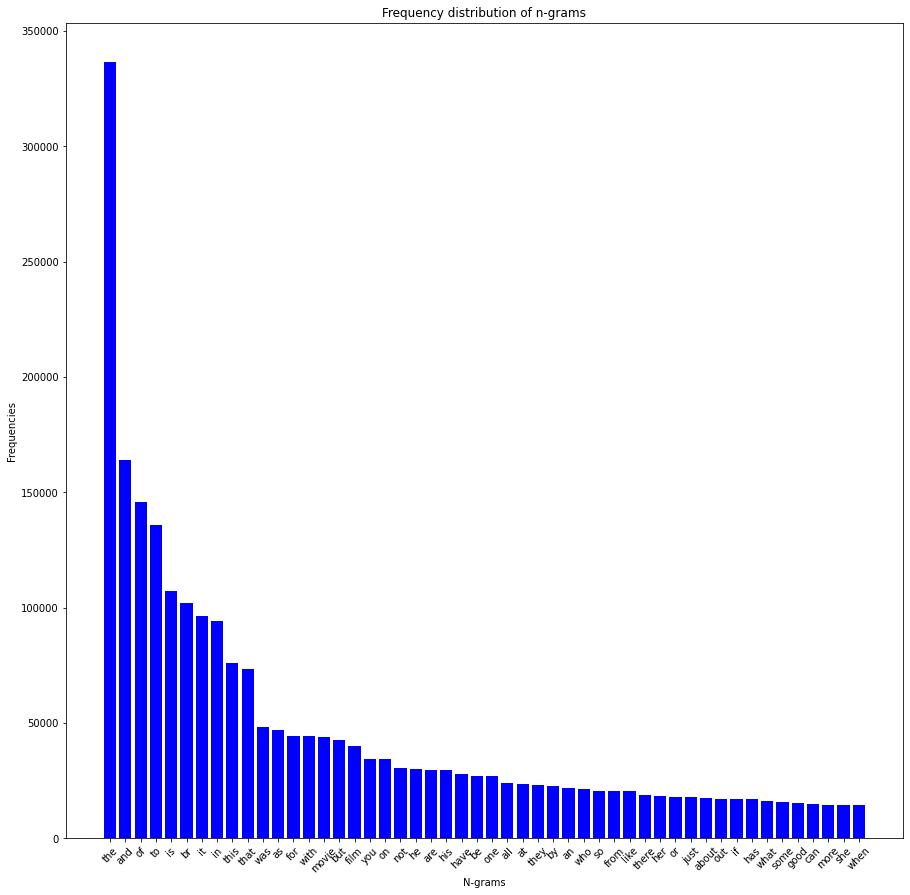

In [ ]:
plot_frequency_distribution_of_ngrams(train_texts)

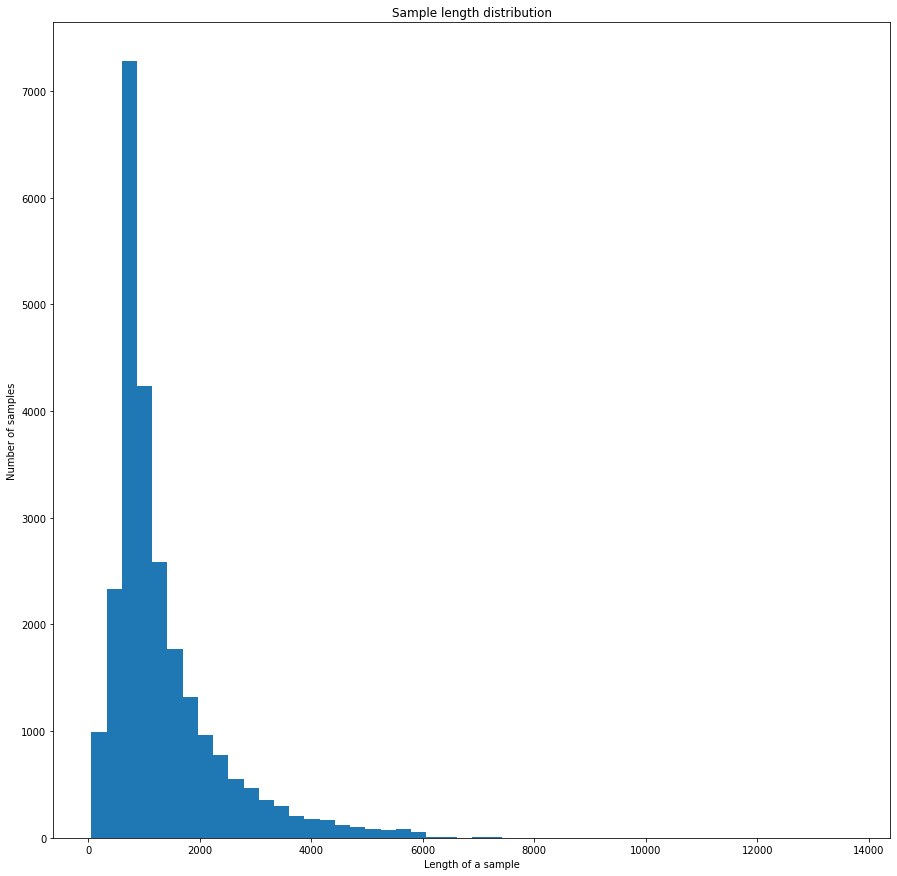

In [ ]:
plot_sample_length_distribution(train_texts)

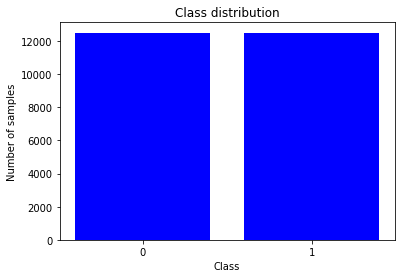

In [ ]:
plot_class_distribution(train_labels)

# Step 2.5: Choose a Model


## Algorithm for Data Preparation and Model Building

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a
simple multi-layer perceptron (MLP) model to classify them (left branch in the
flowchart below):
  a. Split the samples into word n-grams; convert the n-grams into vectors.
  b. Score the importance of the vectors and then select the top 20K using the scores.
  c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a
   sepCNN model to classify them (right branch in the flowchart below):
  a. Split the samples into words; select the top 20K words based on their frequency.
  b. Convert the samples into word sequence vectors.
  c. If the original number of samples/number of words per sample ratio is less
     than 15K, using a fine-tuned pre-trained embedding with the sepCNN
     model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [ ]:
print("the number of samples/number of words per sample ratio: ", len(train_texts)//get_num_words_per_sample(train_texts)) 

the number of samples/number of words per sample ratio:  143.0


![picture](https://developers.google.com/machine-learning/guides/text-classification/images/TextClassificationFlowchart.png)
**Text classification flowchart**

* Which learning algorithm or model should we use?

* How should we prepare the data to efficiently learn the relationship between text and label?

The answer to the second question depends on the answer to the first question; 
*the way we preprocess data to be fed into a model will depend on what model we choose.* 
* **Models can be broadly classified into two categories:**
 1. those that use word ordering information (sequence models), 
 2. and ones that just see text as “bags” (sets) of words (n-gram models). 
 * Types of *sequence models* include **convolutional neural networks (CNNs)**, **recurrent neural networks (RNNs)**, and their variations. 
 * Types of *n-gram models* include **logistic regression**, **simple multi- layer perceptrons** (MLPs, or fully-connected neural networks), **gradient boosted trees** and **support vector machines**.

When the value for this ratio is small (<1500), small multi-layer perceptrons that take n-grams as input (which we'll call Option A) perform better or at least as well as sequence models. MLPs are simple to define and understand, and they take much less compute time than sequence models. When the value for this ratio is large (>= 1500), use a sequence model (Option B).

**In the case of IMDb review dataset, the samples/words-per-sample ratio is ~144. This means that we will create a MLP model.**



# Step 3: Prepare Data


* ٍShould do Shuffle after or befor spilt the data
* Convert the texts to numbers as input to the machine learning model


Machine learning algorithms take numbers as inputs. This means that we will need to convert the texts into numerical vectors. There are two steps to this process:

* **Tokenization:** Divide the texts into words or smaller sub-texts, which will enable good generalization of relationship between the texts and the labels. This determines the “vocabulary” of the dataset (set of unique tokens present in the data).

* **Vectorization:** Define a good numerical measure to characterize these texts.

Now, let's see how to perform these two steps for both **n-gram vectors** and **sequence vectors**, as well as how to optimize the *vector representations using feature selection and normalization techniques*.

### (Optinal A) N-gram Vectors

**The following code puts together all of Tokenization, Vectorization, Feature selection steps:**

1. Tokenize text samples into word uni+bigrams,
2. Vectorize using tf-idf encoding,
3. Select only the top 20,000 features from the vector of tokens by discarding tokens that appear fewer than 2 times and using f_classif to calculate feature importance.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

In [ ]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val, vectorizer.get_feature_names(), selector.get_params()

In [ ]:
ngram_vecto_x_train, ngram_vecto_x_val, feature_names_, parameters_for_SelectKBest_esimator=ngram_vectorize(train_texts=train_texts, train_labels=train_labels, val_texts=test_texts)


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1817: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


In [ ]:
print("The shape of New Train Texts: ", ngram_vecto_x_train.shape)

The shape of New Train Texts:  (25000, 20000)


In [ ]:
len(feature_names_)

438613

**JUST select the most important 20,000 Name Features from the 438613 features name**

In [ ]:
parameters_for_SelectKBest_esimator

{'k': 20000,
 'score_func': <function sklearn.feature_selection._univariate_selection.f_classif>}

###  (Option B) Sequence Vectors

![picture](https://developers.google.com/machine-learning/guides/text-classification/images/EmbeddingLayer.png)

**The following code puts together all of Tokenization, Vectorization, Feature selection steps in sequence vectorization:**

- Tokenizes the texts into words
- Creates a vocabulary using the top 20,000 tokens
- Converts the tokens into sequence vectors
- Pads the sequences to a fixed sequence length

In [ ]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

In [ ]:
def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

In [ ]:
sequence_vectorize_train_texts, sequence_vectorize_test_texts, tokenizer_words_index=sequence_vectorize(train_texts=train_texts, val_texts=test_texts)

In [ ]:
print("The shape of Vectorized Sequence of train texts: ", sequence_vectorize_train_texts.shape)

The shape of Vectorized Sequence of train texts:  (25000, 500)


In [ ]:
print("Example of Sample of texts, This is sequence limited to 500 Feature: \n", sequence_vectorize_train_texts[0])

Example of Sample of texts, This is sequence limited to 500 Feature: 
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0   611
  1025     7     7     1  2537    34    69     6     3  3866     2   117
  5514   751  1957   129     4   733   382   726    4

In [ ]:
print("Every Word selected in Features names has a index, that are: ", len(tokenizer_words_index))

Every Word selected in Features names has a index, that are:  88582


In [ ]:
tokenizer_words_index.items()

dict_items([('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('br', 7), ('in', 8), ('it', 9), ('i', 10), ('this', 11), ('that', 12), ('was', 13), ('as', 14), ('for', 15), ('with', 16), ('movie', 17), ('but', 18), ('film', 19), ('on', 20), ('not', 21), ('you', 22), ('are', 23), ('his', 24), ('have', 25), ('he', 26), ('be', 27), ('one', 28), ('all', 29), ('at', 30), ('by', 31), ('an', 32), ('they', 33), ('who', 34), ('so', 35), ('from', 36), ('like', 37), ('her', 38), ('or', 39), ('just', 40), ('about', 41), ("it's", 42), ('out', 43), ('if', 44), ('has', 45), ('some', 46), ('there', 47), ('what', 48), ('good', 49), ('more', 50), ('when', 51), ('very', 52), ('up', 53), ('no', 54), ('time', 55), ('she', 56), ('even', 57), ('my', 58), ('would', 59), ('which', 60), ('only', 61), ('story', 62), ('really', 63), ('see', 64), ('their', 65), ('had', 66), ('can', 67), ('were', 68), ('me', 69), ('well', 70), ('than', 71), ('we', 72), ('much', 73), ('been', 74), ('bad', 75), ('get'

Here I will convert a sequence vectorized to the original text

In [ ]:
sample_words=[]
sample_vectorized=sequence_vectorize_train_texts[0]

# list out keys and values separately 

words = list(tokenizer_words_index.keys()) 
indexs = list(tokenizer_words_index.values()) 

for i in sample_vectorized:
  if i != 0:
    sample_words.append(words[indexs.index(i)])

In [ ]:
print(sample_words)

['possible', 'spoilers', 'br', 'br', 'the', 'spy', 'who', 'me', 'is', 'a', 'overrated', 'and', 'over', 'hyped', 'sequel', 'international', 'man', 'of', 'mystery', 'came', 'straight', 'out', 'of', 'the', 'blue', 'it', 'was', 'a', 'lone', 'star', 'that', 'few', 'people', 'had', 'heard', 'of', 'but', 'it', 'was', 'stunningly', 'original', 'had', 'sophisticated', 'humour', 'and', 'ample', 'humour', 'always', 'kept', 'in', 'good', 'taste', 'and', 'had', 'a', 'brilliant', 'cast', 'the', 'spy', 'who', 'me', 'was', 'a', 'lot', 'more', 'commercially', 'advertised', 'and', 'hyped', 'about', 'br', 'br', 'ok', "i'll", 'admit', 'the', 'first', 'time', 'i', 'saw', 'this', 'film', 'i', 'thought', 'it', 'was', 'very', 'funny', 'but', "it's", 'only', 'after', 'watching', 'it', 'two', 'or', 'three', 'times', 'that', 'you', 'see', 'all', 'the', 'flaws', 'the', 'acting', 'was', 'ok', 'but', 'heather', 'graham', 'cannot', 'act', 'her', 'performance', "didn't", 'seem', 'very', 'convincing', 'and', 'she', "w

### Label vectorization

* above converts sample text data into numerical vectors. A similar process must be applied to the labels. 
* can simply convert labels into values in range [0, num_classes - 1]. 
* For example, if there are 3 classes we can just use values 0, 1 and 2 to represent them. 
* Internally, the network will use one-hot vectors to represent these values (to avoid inferring an incorrect relationship between labels). 
* This representation depends on the loss function and the last- layer activation function we use in our neural network. 

# Step 4: Build, Train, and Evaluate the Model

## Constructing the Last Layer

When we have only 2 classes (**binary classification**), our model should output a **single probability score**. 
* For instance, outputting 0.2 for a given input sample means **“20% confidence that this sample is in the first class (class 1), 80% that it is in the second class (class 0).”** 
* To output such a probability score, the activation function of the last layer should be a ***sigmoid function***, and the loss function used to train the model should be **binary cross-entropy** .



When there are more than 2 classes (**multi-class classification**), our model should output one probability score per class. 
* The sum of these scores should be 1. 
* For instance, outputting **{0: 0.2, 1: 0.7, 2: 0.1}** means “20% confidence that this sample is in class 0, 70% that it is in class 1, and 10% that it is in class 2.” 
* To output these scores, the activation function of the last layer should be **softmax**, and the loss function used to train the model should be **categorical cross-entropy**.

![picture](https://developers.google.com/machine-learning/guides/text-classification/images/LastLayer.png)

The following code defines a function that takes the number of classes as input, and outputs the appropriate number of layer units (1 unit for binary classification; otherwise 1 unit for each class) and the appropriate activation function:

In [ ]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation



---



* When the**` S/W ratio`** is small, we’ve found that n-gram models perform better than sequence models. 
* Sequence models are better when there are a large number of small, dense vectors. This is because embedding relationships are learned in dense space, and this happens best over many samples.

## (Option A) Build n-gram model

The models that process the tokens independently (not taking into account word order) as **n-gram models**. Simple **multi-layer perceptrons** (including **logistic regression**), **gradient boosting machines** and **support vector machines** models all fall under this category; they cannot leverage any information about text ordering.

* The performance of some of the n-gram models mentioned above and observed that **multi-layer perceptrons (MLPs)** typically perform better than other options. 
* MLPs are simple to define and understand, provide good accuracy, and require relatively little computation.

The following code defines a two-layer MLP model in tf.keras, adding a couple of Dropout layers for regularization (to prevent overfitting to training samples).

In [ ]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

## (Option B) Build sequence model

* The models that can learn from the adjacency of tokens as sequence models. 
* This includes CNN and RNN classes of models. 
* Data is pre-processed as sequence vectors for these models.

* Sequence models generally have a larger number of parameters to learn. 
* The first layer in these models is an **embedding layer**, which learns **the relationship between the words in a dense vector space**. 
* Learning word relationships works best over many samples.

* Words in a given dataset are most likely not unique to that dataset. 
* We can thus learn the relationship between the words in our dataset using other dataset(s). 
* To do so, ***we can transfer an embedding learned from another dataset into our embedding layer***. 
* These embeddings are referred to as **pre-trained embeddings**. 
* Using a **pre-trained embedding** gives the model a head start in the learning process.

* There are** pre-trained embeddings** available that have been trained using large corpora, such as [GloVe](https://nlp.stanford.edu/projects/glove/).
* **GloVe** has been trained on multiple corpora (primarily Wikipedia). 
* We tested training our sequence models using a version of GloVe embeddings and observed that if we froze the weights of the pre-trained embeddings and trained just the rest of the network, the models did not perform well. 
* This could be because the context in which the embedding layer was trained might have been different from the context in which we were using it.

* GloVe embeddings trained on Wikipedia data may not align with the language patterns in our IMDb dataset. 
* The relationships inferred may need some updating—i.e., the embedding weights may need contextual tuning.
*  We do this in two stages:

1. 
  * In **the first run**, with the embedding layer weights frozen, we allow the rest of the network to learn. At the end of this run, the model weights reach a state that is much better than their uninitialized values. 
  * For **the second run**, we allow the embedding layer to also learn, making fine adjustments to all weights in the network. We refer to this process as using a fine-tuned embedding.

2. Fine-tuned embeddings yield better accuracy. However, this comes at the expense of increased compute power required to train the network. Given a sufficient number of samples, we could do just as well learning an embedding from scratch. We observed that for `S/W > 15K`, starting from scratch effectively yields about the same accuracy as using **fine-tuned embedding**.

* We compared different sequence models such as CNN, sepCNN (Depthwise Separable Convolutional Network), RNN (LSTM & GRU), CNN-RNN, and stacked RNN, varying the model architectures. 
* We found that sepCNNs, a convolutional network variant that is often more data-efficient and compute-efficient, perform better than the other models.

**The following code constructs a four-layer sepCNN model:**



In [ ]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

## Train the Model

* We constructed the model architecture, we need to train the model. 
* Training involves making a prediction based on the current state of the model, calculating how incorrect the prediction is, and updating the weights or parameters of the network to minimize this error and make the model predict better. 
* We repeat this process until our model has converged and can no longer learn. 

 **There are three key parameters to be chosen for this process** 

* **Metric:** How to measure the performance of our model using a metric. We used ***accuracy*** as the metric in our experiments.
* **Loss function:** A function that is used to calculate a loss value that the training process then attempts to minimize by tuning the network weights. For ***classification problems, cross-entropy loss works well***.
* **Optimizer:** A function that decides how the network weights will be updated based on the output of the loss function. We used the popular ***Adam optimizer*** in our experiments.

**Learning parameters:**

* Metric: **accuracy**
* Loss function-binary classification:	**binary_crossentropy**
* Loss function-multi class classification: 	**sparse_categorical_crossentropy**
* Optimizer: adam

* The actual training happens using **the fit method**. 
* Depending on the size of your dataset, this is the method in which most compute cycles will be spent.
* In each training iteration, **batch_size** *number of samples from your training data* are used to compute the loss, and the weights are updated once, based on this value.
* The training process completes an epoch once the model has seen the entire training dataset. 
* At the end of each epoch, we use the validation dataset to evaluate how well the model is learning. 
* We repeat training using the dataset for a predetermined number of epochs. 
* We may optimize this by stopping early, when the validation accuracy stabilizes between consecutive epochs, showing that the model is not training anymore.

**Training hyperparameter**
* Learning rate: **1e-3**
* Epochs: **1000**
* Batch size: **512**
* Early stopping	parameter: **val_loss, patience: 1**



---



The Training of all models will be in the second part of this notebook

[The Second Part](https://colab.research.google.com/drive/1iUe93lj7QPXO_8O9tjN0h8V5jXcxHN90?usp=sharing)